In [1]:
import cv2
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.measure import regionprops_table
from skimage.segmentation import clear_border
from scipy import ndimage


## Read Image from Omero Server

In [2]:
import os
import json
import omero
from getpass import getpass
from omero.gateway import BlitzGateway
from omero.rtypes import rstring, rbool
from omero.model import ChecksumAlgorithmI
from omero.model.enums import ChecksumAlgorithmSHA1160
from omero.callbacks import CmdCallbackI


# ### Create a connection to an OMERO server
def connect(hostname, username, password):
    """
    Connect to an OMERO server
    :param hostname: Host name
    :param username: User
    :param password: Password
    :return: Connected BlitzGateway
    """
    conn = BlitzGateway(username, password,
                        host=hostname, secure=True)
    conn.connect()
    conn.c.enableKeepAlive(60)
    return conn

HOST = 'wss://wss.omero.matolab.org'
conn = connect(HOST, input("Username: "),
               getpass("OMERO Password: "))
print("Connected as {}".format(conn.getUser().getName()))
print("User ID: {}".format(conn.getUser().getId()))
print("User Full Name: {}".format(conn.getUser().getFullName()))

Username: ghezal-ahmad.zia@bam.de
OMERO Password: ········
Connected as ghezal-ahmad.zia@bam.de
User ID: 52
User Full Name: Zia Ghezal Ahmad


In [3]:
# Load images in a specified dataset method
def load_images(conn, dataset_id):
    """
    Load the images in the specified dataset
    :param conn: The BlitzGateway
    :param dataset_id: The dataset's id
    :return: The Images or None
    """
    dataset = conn.getObject("Dataset", dataset_id)
    images = []
    for image in dataset.listChildren():
        images.append(image)
    if len(images) == 0:
        return None

    for image in images:
        print("---- Processing image ID:", image.id)
    
    # Print dataset ID and name
    print("Dataset ID:", dataset.getId())
    print("Dataset Name:", dataset.getName())
    
    return images

# Get the images in a dataset and print the dataset ID and name
images = load_images(conn, input("Dataset ID: "))
datasetID = images[0].id
#print(images[0].id)


Dataset ID: 53
---- Processing image ID: 83
---- Processing image ID: 84
---- Processing image ID: 85
---- Processing image ID: 74
---- Processing image ID: 75
---- Processing image ID: 76
---- Processing image ID: 77
---- Processing image ID: 78
---- Processing image ID: 79
---- Processing image ID: 80
---- Processing image ID: 81
---- Processing image ID: 82
Dataset ID: 53
Dataset Name: 190C_1000h


In [4]:
image_id = int(input('Enter Image ID: '))
# Pixels and Channels will be loaded automatically as needed
image = conn.getObject("Image", image_id)

# Retrieve information about the image
print("Image Name:", image.getName())
print("Image Description:", image.getDescription())
print("Image SizeX:", image.getSizeX())
print("Image SizeY:", image.getSizeY())
print("Image SizeZ:", image.getSizeZ())
print("Image SizeC:", image.getSizeC())
print("Image SizeT:", image.getSizeT())

x = image.getName()

# List Channels (loads the Rendering settings to get channel colors)
for channel in image.getChannels():
    print('Channel:', channel.getLabel())
    print('Color:', channel.getColor().getRGB())
    print('Lookup table:', channel.getLut())
    print('Is reverse intensity?', channel.isReverseIntensity())
    

print(image.countImportedImageFiles())
file_count = image.countFilesetFiles()
# list files
if file_count > 0:
    for orig_file in image.getImportedImageFiles():
        name = orig_file.getName()
        path = orig_file.getPath()
        print(name)
        print(path)

# render the first timepoint, mid Z section
z = image.getSizeZ() / 2
t = 0
rendered_image = image.renderImage(z, t)
image = np.asarray(rendered_image)


# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

### Time estimation of the pipeline
import time
startTime = time.time()

x = x.split('_')
#MaterialState (T61), Sample (Sample1), Image (Stelle1)
x

Enter Image ID: 84
Image Name: 190C-1000h_Sample1_Stelle 11 DF 30s.dm3
Image Description: 
Image SizeX: 2048
Image SizeY: 2048
Image SizeZ: 1
Image SizeC: 1
Image SizeT: 1
Channel: 0
Color: (128, 128, 128)
Lookup table: None
Is reverse intensity? False
1
Stelle 11 DF 30s.dm3
ghezal-ahmad.zia@bam.de_52/2023-02/22/15-13-20.526/


['190C-1000h', 'Sample1', 'Stelle 11 DF 30s.dm3']

Grayscale image shape: (2048, 2048)
Grayscale image data type: uint8


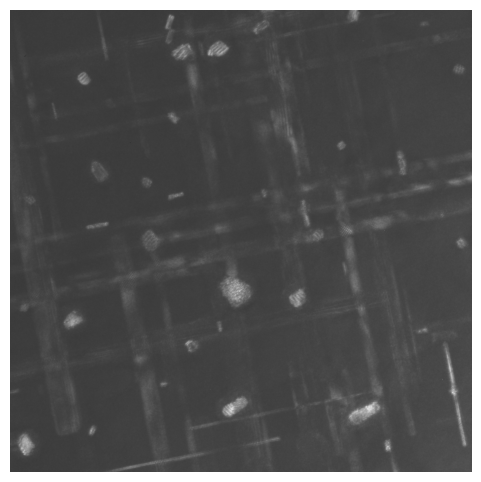

In [5]:
# Print the shape and data type of the grayscale image
print("Grayscale image shape:", gray.shape)
print("Grayscale image data type:", gray.dtype)

# Display the grayscale image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image, cmap='gray')
ax.axis('off')
plt.show()


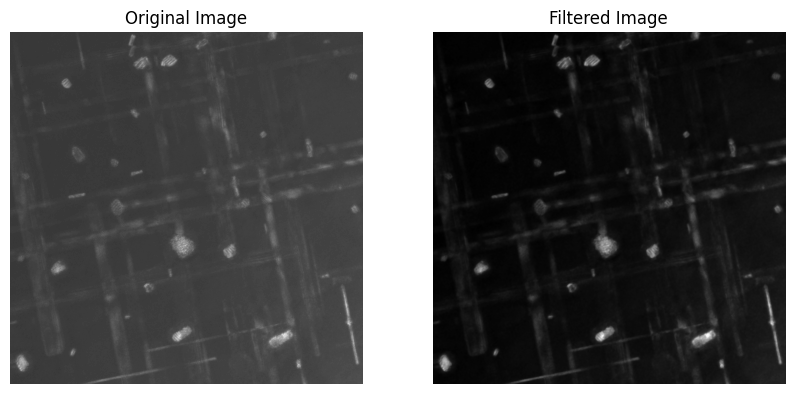

In [6]:
# Apply median filter using OpenCV
radius = 4
selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius + 1, 2*radius+1))
filtered = cv2.medianBlur(gray, 2 * radius + 1)

# Display the original and filtered images side by side
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(gray, cmap='gray')
ax0.set_title('Original Image')
ax0.axis('off')
ax1.imshow(filtered, cmap='gray')
ax1.set_title('Filtered Image')
ax1.axis('off')
plt.show()

Threshold value is 89.0


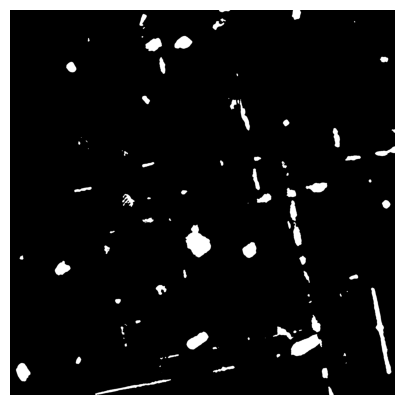

In [7]:
# Apply Otsu's thresholding using OpenCV
ret, thresh = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print('Threshold value is {}'.format(ret))

# Display the thresholded image using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(thresh, cmap='gray')
plt.axis("off")
plt.show()


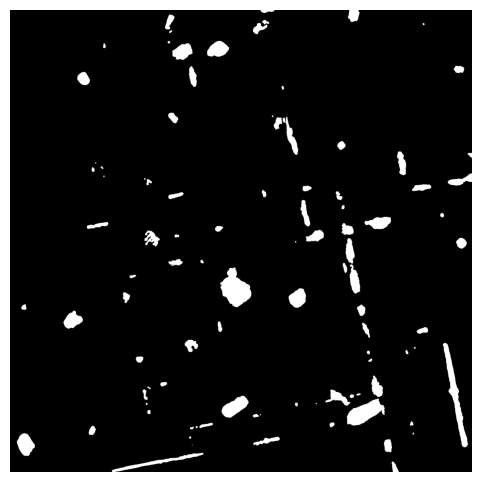

In [8]:
# Dilate the thresholded image using a 3x3 kernel
kernel = np.ones((3,3), np.uint8)
dilated = cv2.dilate(thresh, kernel)

# Display the dilated image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(dilated, cmap='gray')
ax.axis('off')
plt.show()

In [9]:
# Remove small objects using OpenCV's morphologyEx function
size_thresh = 80
morphed = cv2.morphologyEx(dilated, cv2.MORPH_OPEN, kernel, iterations=1)
contours, hierarchy = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < size_thresh:
        cv2.drawContours(morphed, [cnt], 0, 0, -1)

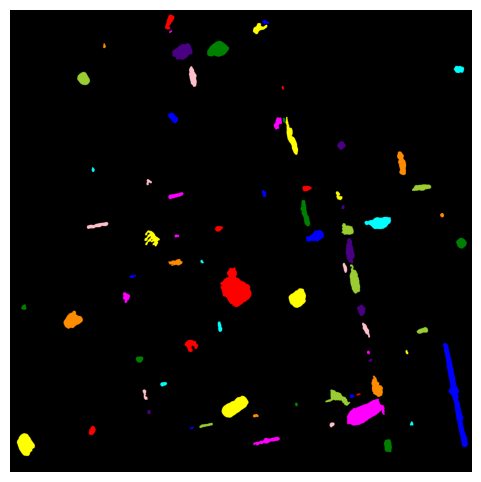

Number of precipitates detected: 75


In [10]:
# Apply clear border to the dilated image
mask = morphed  == 255
mask = clear_border(mask)

# Label the mask and count the number of precipitates detected
s = [[1,1,1],[1,1,1],[1,1,1]]
labeled_mask, num_labels = ndimage.label(mask, structure=s)
img2 = label2rgb(labeled_mask, bg_label=0)

# Display the labeled mask
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img2)
ax.axis('off')
plt.show()
print(f"Number of precipitates detected: {num_labels}")


In [1339]:
# Extract properties of each labeled region
props = regionprops_table(labeled_mask, image, properties=('area',
                                                                    'axis_major_length',
                                                                   'axis_minor_length',
                                                                      'centroid',))

# Create a Pandas dataframe from the properties
df = pd.DataFrame(props)

In [1340]:
df.head()

,area,axis_major_length,axis_minor_length,centroid-0,centroid-1
0,9384,136.784911,100.850396,94.843031,477.007779
1,990,48.368877,26.424501,138.777778,133.990909
2,6272,107.075037,82.270332,341.251754,926.656091
3,611,46.289766,21.498486,463.384615,868.649755
4,3899,90.011238,55.965945,592.652475,935.979995


In [1341]:
#To delete small regions...
df = df[df['area'] > 50]
df.head()

,area,axis_major_length,axis_minor_length,centroid-0,centroid-1
0,9384,136.784911,100.850396,94.843031,477.007779
1,990,48.368877,26.424501,138.777778,133.990909
2,6272,107.075037,82.270332,341.251754,926.656091
3,611,46.289766,21.498486,463.384615,868.649755
4,3899,90.011238,55.965945,592.652475,935.979995


In [1342]:
area_in_nm2 = df['area'] * 0.0225
df['area_in_nm2'] = area_in_nm2

In [1343]:
radius_in_nm = np.sqrt(df['area_in_nm2']/math.pi)

In [1344]:
df['radius_in_nm'] = radius_in_nm

In [1345]:
aspect_ratio = df['axis_major_length']/df['axis_minor_length']

In [1346]:
df.insert(3, 'aspect_ratio', aspect_ratio)

In [1347]:
df.head(5)

,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm
0,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045
1,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772
2,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230
3,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881
4,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367


### Creating the Meta-data

In [1348]:
date = pd.Timestamp("today").strftime("%Y-%m-%d")

In [1349]:
header = {'BitSizeValue': radius , 
          'DiskRadiusValue[pixel]': 8,
          'OtsuThresholdValue[np]': 'Otsu',
          'KernelValue':3,
          'MaskSetValue':255, 
          'BG_LabelValue':0,
          'Date':date}

In [1350]:
df_header= pd.DataFrame([header])

In [1351]:
df_header.head(4)

,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date
0,4,8,Otsu,3,255,0,2023-04-05


### Joining the meta-data to the dataframe

In [1352]:
df_join = df.join(df_header, rsuffix='_right')
df_join.head(5)

,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date
0,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
1,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1353]:
# filling the NaN values
df_join=df_join.fillna(method='ffill')
df_join.tail(5)

,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date
21,731,51.693956,22.115508,2.337453,1776.905609,1725.340629,16.4475,2.288100,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
22,112,12.546236,11.380204,1.102461,1912.223214,1874.250000,2.5200,0.895623,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
23,144,15.267990,12.038693,1.268243,1914.729167,1892.145833,3.2400,1.015541,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
24,107,12.786384,10.634679,1.202329,1939.728972,1913.934579,2.4075,0.875403,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
25,332,28.529056,15.152586,1.882785,1976.888554,377.057229,7.4700,1.542004,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05


### Creating informative columns 

In [1354]:
df_join['Precipitate#'] = range(1,len(df_join)+1)
df_join.head(5)

,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date,Precipitate#
0,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,1
1,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,2
2,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,3
3,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,4
4,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,5


In [1355]:

desc = {'MaterialState':x[0] , 
         'Sample': x[1],
          'Image': x[2],
         }

df_desc= pd.DataFrame([desc])
df_desc.head()

,MaterialState,Sample,Image
0,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3


In [1356]:
#df_join = df.join(df_desc, lsuffix='_MaterialState')
frames = [df_desc, df_join]

result = pd.concat(frames, axis="columns")
result.head(5)

,MaterialState,Sample,Image,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date,Precipitate#
0,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,1
1,NaN,NaN,NaN,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,2
2,NaN,NaN,NaN,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,3
3,NaN,NaN,NaN,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,4
4,NaN,NaN,NaN,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,5


In [1357]:
# Fill the missing data
df_join=result.fillna(method='ffill')
df_join.tail(5)

,MaterialState,Sample,Image,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-0,centroid-1,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date,Precipitate#
21,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,731,51.693956,22.115508,2.337453,1776.905609,1725.340629,16.4475,2.288100,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,22
22,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,112,12.546236,11.380204,1.102461,1912.223214,1874.250000,2.5200,0.895623,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,23
23,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,144,15.267990,12.038693,1.268243,1914.729167,1892.145833,3.2400,1.015541,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,24
24,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,107,12.786384,10.634679,1.202329,1939.728972,1913.934579,2.4075,0.875403,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,25
25,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV.dm3,332,28.529056,15.152586,1.882785,1976.888554,377.057229,7.4700,1.542004,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05,26


In [1358]:
df_join['Image'] = df_join['Image'].str.replace('.dm3', '', regex=True)

In [1359]:
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

In [1360]:
df_final_result = change_column_order(df_join, 'Precipitate#', 3)

In [1361]:
df_final_result = df_final_result.rename(columns={"centroid-0": "centroid-X", "centroid-1": "centroid-Y"})

In [1362]:
df_final_result.head(5)

,MaterialState,Sample,Image,Precipitate#,area,axis_major_length,axis_minor_length,aspect_ratio,centroid-X,centroid-Y,area_in_nm2,radius_in_nm,BitSizeValue,DiskRadiusValue[pixel],OtsuThresholdValue[np],KernelValue,MaskSetValue,BG_LabelValue,Date
0,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,1,9384,136.784911,100.850396,1.356315,94.843031,477.007779,211.1400,8.198045,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
1,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,2,990,48.368877,26.424501,1.830456,138.777778,133.990909,22.2750,2.662772,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
2,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,3,6272,107.075037,82.270332,1.301502,341.251754,926.656091,141.1200,6.702230,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
3,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,4,611,46.289766,21.498486,2.153164,463.384615,868.649755,13.7475,2.091881,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05
4,190C-2500h,Sample2,Stelle12 DF 30s Spot 3 alpha 1 deltaE 15eV,5,3899,90.011238,55.965945,1.608322,592.652475,935.979995,87.7275,5.284367,4.0,8.0,Otsu,3.0,255.0,0.0,2023-04-05


In [1363]:
df_final_result.to_csv('190c_2500h_1iteration.csv',  header=False, mode='a',index=False, date_format='%s')